# Imports

In [1]:
from sklearn.metrics import classification_report, f1_score
import panel as pn 
import re
import operator

## Functions

In [2]:
from my_function import *
from plot_function import *

# Init Dataframe

In [3]:
# Set audio snippets and sample compression
offset_sec = 0.01
duration_sec = 0.06
num_data_points = 50

# Create empty Dataframe
df_cols = ['dataset', 'audio_file_name', 'pitch', 'onset_sec', 'amplitude', 'frequency']
path_main = "IDMT-SMT-GUITAR_V2_MOD/"

# Create Dataframe with reference tones

In [4]:
%%time
df_ref = pd.DataFrame(columns=df_cols)
path_main_ref = path_main + "dataset1/Fender Strat Clean Neck SC/"
df_ref = read_xml_to_df(path_main_ref, df_cols, offset_sec, duration_sec, num_data_points)
df_ref.head()

Wall time: 299 ms


,dataset,audio_file_name,pitch,onset_sec,amplitude,frequency
0,dataset1/Fender Strat Clean Neck SC,G53-40100-1111-00001.wav,[40],0.2,"[0.016415700273119366, 0.013539001215847018, 0...","[0.0, 16.67927382753404, 33.35854765506808, 50..."
1,dataset1/Fender Strat Clean Neck SC,G53-41101-1111-00002.wav,[41],0.2,"[0.01196179939207087, 0.009811175513489997, 0....","[0.0, 16.67927382753404, 33.35854765506808, 50..."
2,dataset1/Fender Strat Clean Neck SC,G53-42102-1111-00003.wav,[42],0.2,"[0.027405693705284964, 0.03556278609983192, 0....","[0.0, 16.67927382753404, 33.35854765506808, 50..."
3,dataset1/Fender Strat Clean Neck SC,G53-43103-1111-00004.wav,[43],0.2,"[0.003594247643871954, 0.015482101158757979, 0...","[0.0, 16.67927382753404, 33.35854765506808, 50..."
4,dataset1/Fender Strat Clean Neck SC,G53-44104-1111-00005.wav,[44],0.2,"[0.041095695882892636, 0.05529281274484641, 0....","[0.0, 16.67927382753404, 33.35854765506808, 50..."


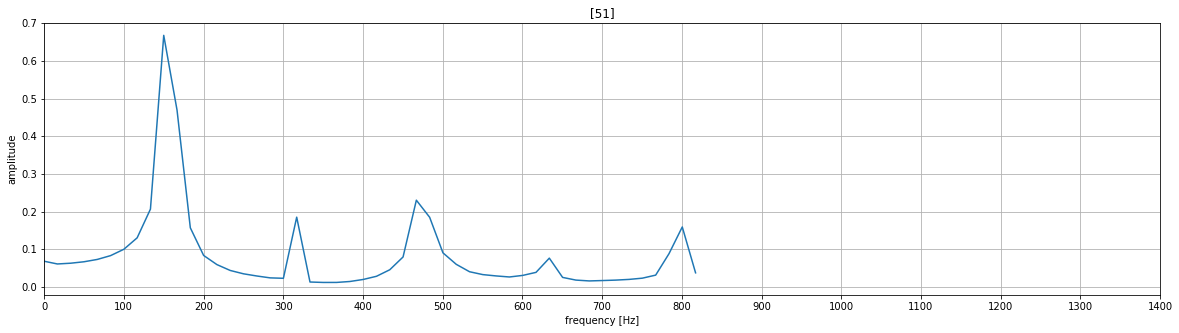

Datapoints:  50


In [5]:
pitch = 18
plot_freq_domain(df_ref.frequency[pitch], df_ref.amplitude[pitch], df_ref.pitch[pitch])
print('Datapoints: ', len(df_ref.amplitude[pitch]))

In [6]:
# Create dataframe with unique pitches (only one is used if the pitches are the same)
df_ref_unique = pd.DataFrame(columns=df_cols)

for index, row in df_ref.iterrows():
    if not df_ref_unique.pitch.str.contains(row.pitch[0], regex=False).any():
        df_ref_unique = df_ref_unique.append(row, ignore_index=True)
df_ref_unique.head()

,dataset,audio_file_name,pitch,onset_sec,amplitude,frequency
0,dataset1/Fender Strat Clean Neck SC,G53-40100-1111-00001.wav,[40],0.2,"[0.016415700273119366, 0.013539001215847018, 0...","[0.0, 16.67927382753404, 33.35854765506808, 50..."
1,dataset1/Fender Strat Clean Neck SC,G53-41101-1111-00002.wav,[41],0.2,"[0.01196179939207087, 0.009811175513489997, 0....","[0.0, 16.67927382753404, 33.35854765506808, 50..."
2,dataset1/Fender Strat Clean Neck SC,G53-42102-1111-00003.wav,[42],0.2,"[0.027405693705284964, 0.03556278609983192, 0....","[0.0, 16.67927382753404, 33.35854765506808, 50..."
3,dataset1/Fender Strat Clean Neck SC,G53-43103-1111-00004.wav,[43],0.2,"[0.003594247643871954, 0.015482101158757979, 0...","[0.0, 16.67927382753404, 33.35854765506808, 50..."
4,dataset1/Fender Strat Clean Neck SC,G53-44104-1111-00005.wav,[44],0.2,"[0.041095695882892636, 0.05529281274484641, 0....","[0.0, 16.67927382753404, 33.35854765506808, 50..."


In [7]:
# Create dataframe with averaged pitches
df_ref_merge = pd.DataFrame(columns=df_cols)
for index, row in df_ref.iterrows():
    if not df_ref_merge.pitch.str.contains(row.pitch[0], regex=False).any():
        df_ref_merge = df_ref_merge.append(row, ignore_index=True)
    else:
        ind = df_ref_merge.pitch.str.contains(row.pitch[0], regex=False).tolist().index(True)
        amplitude_a = df_ref_merge.amplitude[ind]
        amplitude_b = row.amplitude
        amplitude_sum = np.asarray([sum(x) for x in zip(amplitude_a, amplitude_b)])
        df_ref_merge.at[ind, 'amplitude'] = amplitude_sum

# normalise
for index, row in df_ref_merge.iterrows():
    df_ref_merge.at[index, 'amplitude'] = norm_vec(row.amplitude)

### Assign reference dataframe

In [8]:
#df_ref_mod = df_ref_unique
df_ref_mod = df_ref_merge
df_ref_mod.head()

,dataset,audio_file_name,pitch,onset_sec,amplitude,frequency
0,dataset1/Fender Strat Clean Neck SC,G53-40100-1111-00001.wav,[40],0.2,"[0.016415700273119366, 0.013539001215847018, 0...","[0.0, 16.67927382753404, 33.35854765506808, 50..."
1,dataset1/Fender Strat Clean Neck SC,G53-41101-1111-00002.wav,[41],0.2,"[0.01196179939207087, 0.009811175513489997, 0....","[0.0, 16.67927382753404, 33.35854765506808, 50..."
2,dataset1/Fender Strat Clean Neck SC,G53-42102-1111-00003.wav,[42],0.2,"[0.027405693705284968, 0.035562786099831926, 0...","[0.0, 16.67927382753404, 33.35854765506808, 50..."
3,dataset1/Fender Strat Clean Neck SC,G53-43103-1111-00004.wav,[43],0.2,"[0.0035942476438719545, 0.01548210115875798, 0...","[0.0, 16.67927382753404, 33.35854765506808, 50..."
4,dataset1/Fender Strat Clean Neck SC,G53-44104-1111-00005.wav,[44],0.2,"[0.041095695882892636, 0.05529281274484641, 0....","[0.0, 16.67927382753404, 33.35854765506808, 50..."


# Create Dataframe with testdatas

In [9]:
%%time
df_test = pd.DataFrame(columns=df_cols)

path_testdata = [
    path_main + 'dataset1/Fender Strat Clean Neck SC/',
    path_main + 'dataset1/Fender Strat Clean Neck SC Chords/',
    path_main + 'dataset1/Ibanez Power Strat Clean Bridge HU/',
    path_main + 'dataset1/Ibanez Power Strat Clean Bridge HU Chords/',
    path_main + 'dataset1/Ibanez Power Strat Clean Bridge+Neck SC/',
    path_main + 'dataset1/Ibanez Power Strat Clean Neck HU/',
    path_main + 'dataset2/',
    path_main + 'datasetRecording/']

#for path in path_testdata[:2]:
for path in path_testdata:
    df_act = read_xml_to_df(path, df_cols, offset_sec, duration_sec, num_data_points)
    df_test = df_test.append(df_act, ignore_index=True)

df_test['mono_poly'] = df_test.pitch.apply(lambda x: len(x))
df_test.head()

Wall time: 6.57 s


,dataset,audio_file_name,pitch,onset_sec,amplitude,frequency,mono_poly
0,dataset1/Fender Strat Clean Neck SC,G53-40100-1111-00001.wav,[40],0.2,"[0.016415700273119366, 0.013539001215847018, 0...","[0.0, 16.67927382753404, 33.35854765506808, 50...",1
1,dataset1/Fender Strat Clean Neck SC,G53-41101-1111-00002.wav,[41],0.2,"[0.01196179939207087, 0.009811175513489997, 0....","[0.0, 16.67927382753404, 33.35854765506808, 50...",1
2,dataset1/Fender Strat Clean Neck SC,G53-42102-1111-00003.wav,[42],0.2,"[0.027405693705284964, 0.03556278609983192, 0....","[0.0, 16.67927382753404, 33.35854765506808, 50...",1
3,dataset1/Fender Strat Clean Neck SC,G53-43103-1111-00004.wav,[43],0.2,"[0.003594247643871954, 0.015482101158757979, 0...","[0.0, 16.67927382753404, 33.35854765506808, 50...",1
4,dataset1/Fender Strat Clean Neck SC,G53-44104-1111-00005.wav,[44],0.2,"[0.041095695882892636, 0.05529281274484641, 0....","[0.0, 16.67927382753404, 33.35854765506808, 50...",1


In [10]:
#df_test = df_test.loc[df_test.mono_poly == 1].reset_index()
#df_test

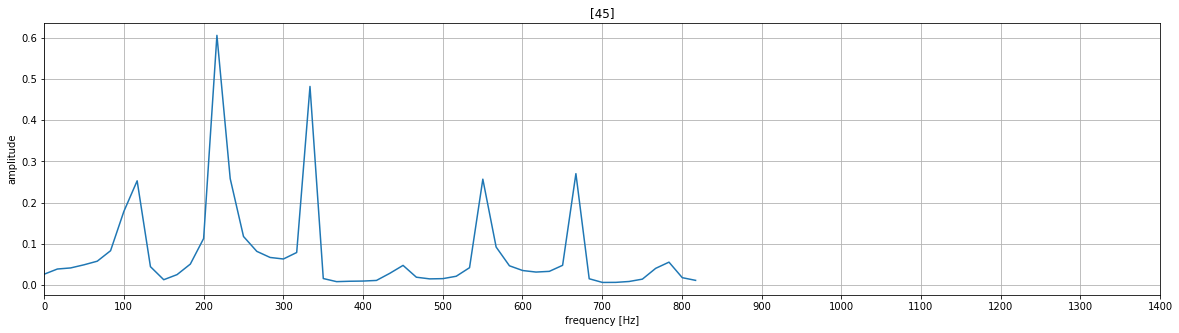

Datapoints:  50


In [11]:
pitch = 6
plot_freq_domain(df_test.frequency[pitch], df_test.amplitude[pitch], df_test.pitch[pitch])
print('Datapoints: ', len(df_ref.amplitude[pitch]))

## Histogram of Pitches Distribution

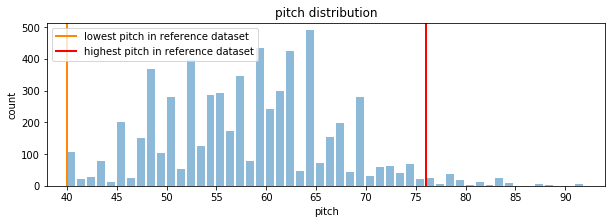

In [12]:
all_pitches_temp = df_test.pitch.tolist()

# flatten List
all_pitches = []
for sublist in all_pitches_temp:
    for item in sublist:
        all_pitches.append(item)

plot_hist(all_pitches, min(df_ref_mod.pitch), max(df_ref_mod.pitch), 10, 3)

In [13]:
# Calc all target vectors
target_pitches = df_test.pitch.array
target_vec = []

for pitch in target_pitches:
    target_vec.append(calc_target_vec(pitch))

df_test['target_vec'] = target_vec

Pitch [77] does not lie within the range(40 - 76)!
Pitch [78] does not lie within the range(40 - 76)!
Pitch [79] does not lie within the range(40 - 76)!
Pitch [78] does not lie within the range(40 - 76)!
Pitch [78] does not lie within the range(40 - 76)!
Pitch [78] does not lie within the range(40 - 76)!
Pitch [78] does not lie within the range(40 - 76)!
Pitch [77] does not lie within the range(40 - 76)!
Pitch [78] does not lie within the range(40 - 76)!
Pitch [79] does not lie within the range(40 - 76)!
Pitch [80] does not lie within the range(40 - 76)!
Pitch [81] does not lie within the range(40 - 76)!
Pitch [82] does not lie within the range(40 - 76)!
Pitch [83] does not lie within the range(40 - 76)!
Pitch [84] does not lie within the range(40 - 76)!
Pitch [78] does not lie within the range(40 - 76)!
Pitch [83] does not lie within the range(40 - 76)!
Pitch [87] does not lie within the range(40 - 76)!
Pitch [92] does not lie within the range(40 - 76)!
Pitch [78] does not lie within 

# Gurobi

In [14]:
# Build Model
m = Model('AMt')

lambs = []
bins = []
signal = []
for lamb in range(len(df_ref_mod)):
    lambs.append(m.addVar(lb = 0, ub = 1, vtype = GRB.CONTINUOUS, name = 'lamb_' + str(lamb)))
    bins.append(m.addVar(vtype = GRB.BINARY, name = 'bin_' + str(lamb)))

amplitudes = df_test.amplitude.tolist()
len_amplitude = len(amplitudes[0])

for datapoint in range(len_amplitude):
    signal.append(m.addVar(lb = 0, ub = 1, vtype = GRB.CONTINUOUS, name = 'x_' + str(datapoint)))
    
m.update()
m.printStats()

Using license file C:\Users\KennethSteiner\gurobi.lic
Academic license - for non-commercial use only

Statistics for model AMt :
  Linear constraint matrix    : 0 Constrs, 124 Vars, 0 NZs
  Variable types              : 87 Continuous, 37 Integer (37 Binary)
  Matrix coefficient range    : [ 0, 0 ]
  Objective coefficient range : [ 0, 0 ]
  Variable bound range        : [ 1, 1 ]
  RHS coefficient range       : [ 0, 0 ]


In [15]:
pred_vec = []
grb_time = 0
alpha = 0

len_lambs = len(lambs)
ref_tones = df_ref_mod.amplitude.tolist()
deviation = m.addVar(lb = -37, ub = 1, vtype = GRB.CONTINUOUS) # +1 Continuous

#Constraints
for i in range(len_lambs):
    m.addConstr(lambs[i] <= bins[i]) # +37 Constrs, + 2*37 NZs

m.addConstr(quicksum(bins) <= 1) # +1 Constrs, +37NZs    
#m.addConstr(quicksum(bins) <= 6) # +1 Constrs, +37NZs

m.update()
m.printStats()


Statistics for model AMt :
  Linear constraint matrix    : 38 Constrs, 125 Vars, 111 NZs
  Variable types              : 88 Continuous, 37 Integer (37 Binary)
  Matrix coefficient range    : [ 1, 1 ]
  Objective coefficient range : [ 0, 0 ]
  Variable bound range        : [ 1, 37 ]
  RHS coefficient range       : [ 1, 1 ]


In [ ]:
%%time

for amplitude in amplitudes:
    cost_function = 0
    penalty = 0
    
    #for i in range(len_lambs):
        #penalty += lambs[i] * lambs[i]
        #penalty += lambs[i]
    
    for f in range(len_amplitude):
        signal[f].lb = signal[f].ub = amplitude[f]
    
    for f in range(len_amplitude):
        approx_sgn = 0
        
        for r in range(len_lambs):
            approx_sgn += ref_tones[r][f] * lambs[r]

        deviation = signal[f] - approx_sgn
        cost_function += deviation * deviation
    
    #Params
    m.params.outputflag = 0 #infotext
    #m.params.Presolve = 0
    
    m.setObjective(cost_function + alpha * penalty, GRB.MINIMIZE)
    m.optimize()
    
    grb_time += m.Runtime
    approx_v = []

    for v in m.getVars():
        #print('%s: %g' % (v.varName, v.x))
        if re.match(r'lamb', v.varName):
            approx_v.append(v.x)

    pred_vec.append(approx_v)
    
df_test['pred_vec'] = pred_vec
df_test.head()

In [ ]:
# normalize pred_vec
%time
norm_pred_vec = []

for j in range(len(df_test.pred_vec)):
    thresh_vec = []
    vec = norm_vec(df_test.pred_vec[j])        
    norm_pred_vec.append(vec)

df_test['norm_pred_vec'] = norm_pred_vec
df_test.head()

# Calculate Pitch Score

In [ ]:
pitch_score = []

for vec in range(len(pred_vec)):
    pitch_score.append(metric(target_vec[vec], np.asarray(norm_pred_vec[vec])))
    
df_test['pitch_score'] = pitch_score
df_test.head()

# Threshold

In [ ]:
%time
threshold = 0

combi_target_vec = []
for i in df_test.target_vec:
    for elem in i:
        combi_target_vec.append(elem)

f1_dict = {}
while threshold <= 1:
    thresholded_vec = []

    for j in range(len(df_test.norm_pred_vec)):
        thresh_vec = []
        vec = df_test.norm_pred_vec[j]

        for i in range(len(vec)):
            if vec[i] >= threshold:
                thresh_vec.append(1)
            else:
                thresh_vec.append(0)

        thresholded_vec.append(thresh_vec)

        
    combi_pred_vec = []
    for i in thresholded_vec:

        for elem in i:
            combi_pred_vec.append(elem)
    
    f1 = round(f1_score(combi_target_vec, combi_pred_vec), 2)
    #print('F1 score: {}, Threshold: {}'.format(f1, threshold))
    f1_dict.update( {threshold : f1} )
    threshold = round(threshold + 0.01, 2)

threshold = max(f1_dict.items(), key=operator.itemgetter(1))[0]
print('Best threshold: ', threshold)

In [ ]:
# calc vector with best threshold
thresholded_vec = []
pitch_pred = []

for j in range(len(df_test.norm_pred_vec)):
    thresh_vec = []
    vec = df_test.norm_pred_vec[j]
    
    for i in range(len(vec)):
        if vec[i] >= threshold:
            thresh_vec.append(1)
        else:
            thresh_vec.append(0)
            
    thresholded_vec.append(thresh_vec)
    pitch_pred.append(vec_to_pitch(thresh_vec))
    
df_test['thresholded_vec'] = thresholded_vec
df_test['pitch_pred'] = pitch_pred
df_test.head()

In [ ]:
test_pitch = 1
plot_bar(df_test, test_pitch, 10, 4, threshold)

# Save/Load Dataframe

In [ ]:
#df_test.to_pickle('all_datasets')

In [ ]:
#df_test = pd.read_pickle('all_datasets')

# Scores

In [ ]:
combi_target_vec = []
for i in df_test.target_vec:
    for elem in i:
        combi_target_vec.append(elem)

combi_pred_vec = []
for i in df_test.thresholded_vec:

    for elem in i:
        combi_pred_vec.append(elem)
#print(round(f1_score(combi_target_vec, combi_pred_vec), 2))

# Boxplots

In [ ]:
mono_score = df_test.loc[df_test.mono_poly == 1].pitch_score
poly_score = df_test.loc[df_test.mono_poly > 1].pitch_score
plot_box(mono_score, poly_score, 4, 4)

# Scatterplot

In [ ]:
mono_pitches = []
mono_pitches_pred = []
undetected = 95
df_mono = df_test.loc[df_test.mono_poly == 1]

for index, row in df_mono.iterrows():
    len_pitch_pred = len(row.pitch_pred) 
    #print('Index: {}, Pitch: {}, Länge: {}'.format(index, row.pitch, len_pitch_pred))
    
    if len_pitch_pred == 0:
        mono_pitches.append(row.pitch)
        mono_pitches_pred.append(undetected)
    else:
        for item in row.pitch_pred:
            mono_pitches.append(row.pitch)
            mono_pitches_pred.append(item)
            
plot_scatter(mono_pitches_pred, mono_pitches, 6, 6)

# Dashboard

In [ ]:
used_datasets = df_test.dataset.unique()
text_dataset = ''
    
for i, text in enumerate(used_datasets):
    text_dataset += text
    if i < len(used_datasets)-1:
        text_dataset += '<br>'
    else:
        text_dataset += '</p>'

tbl_dataset = (
'<table>'
    '<tr>'
        '<th>test dataset:</th>'
    '</tr>'
    '<tr>'
        '<td>' + text_dataset + '</td>'
    '</tr>'
'</table>'
)

In [ ]:
report = classification_report(combi_target_vec, combi_pred_vec, output_dict=True)
zero = '0'
one = '1'
macro = 'macro avg'
weight = 'weighted avg'
 
class_report = (
'<table>'
  '<tr>'
    '<th></th>'
    '<th>precision</th>'
    '<th>recall</th>'
    '<th>f1-score</th>'
  '</tr>'
  '<tr>'
    '<td>' + zero +'</td>'
    '<td>' + str(round(report[zero]['precision'], 2)) + '</td>'
    '<td>' + str(round(report[zero]['recall'], 2)) + '</td>'
    '<td>' + str(round(report[zero]['f1-score'], 2)) + '</td>'
  '</tr>'
  '<tr>'
    '<td>' + one +'</td>'
    '<td>' + str(round(report[one]['precision'], 2)) + '</td>'
    '<td>' + str(round(report[one]['recall'], 2)) + '</td>'
    '<td>' + str(round(report[one]['f1-score'], 2)) + '</td>'
  '</tr>'
  '<tr>'
    '<td>accuracy</td>'
    '<td>''</td>'
    '<td>''</td>'
    '<td>' + str(round(report['accuracy'], 2)) + '</td>'
  '</tr>'
  '<tr>'
    '<td>' + macro +'</td>'
    '<td>' + str(round(report[macro]['precision'], 2)) + '</td>'
    '<td>' + str(round(report[macro]['recall'], 2)) + '</td>'
    '<td>' + str(round(report[macro]['f1-score'], 2)) + '</td>'
  '</tr>'
  '<tr>'
    '<td>' + weight +'</td>'
    '<td>' + str(round(report[weight]['precision'], 2)) + '</td>'
    '<td>' + str(round(report[weight]['recall'], 2)) + '</td>'
    '<td>' + str(round(report[weight]['f1-score'], 2)) + '</td>'
  '</tr>'
'</table> '
)

In [ ]:
mono_count = len(df_test.loc[df_test.mono_poly==1])
poly_count = len(df_test.loc[df_test.mono_poly>1])

text_info = (
'<style>'
'table, th, td {'
    'font-size: 11px;'
    'text-align: left;'
'}'
    
'th, td {'
    'padding: 0px;'
'}'
'</style>'

'<table>'
  '<tr>'
    '<th>number of monophonics:</th>'
    '<td>' + str(mono_count) + '</td>'
  '</tr>'
  '<tr>'
    '<th>number of polyphonics:</th>'
    '<td>' + str(poly_count) + '</td>'
  '</tr>'
  '<tr>'
    '<th>audio offset [s]:</th>'
    '<td>' + str(offset_sec) + '</td>'
  '</tr>'
  '<tr>'
    '<th>data points of audiosnippets:</th>'
    '<td>' + str(len(df_ref_mod.amplitude[0])) + '</td>'
  '</tr>'
  '<tr>'
    '<th>length of audiosnippets [s]:</th>'
    '<td>' + str(duration_sec) + '</td>'
  '</tr>'
  '<tr>'
    '<th>Gurobi regularisation factor:</th>'
    '<td>' + str(alpha) + '</td>'
  '</tr>'
  '<tr>'
    '<th>Gurobi calculation time [s]:</th>'
    '<td>' + str(round(grb_time, 2)) + '</td>'
  '</tr>'
  '<tr>'
    '<th>Threshold:</th>'
    '<td>' + str(threshold) + '</td>'
  '</tr>'
'</table> '
)

In [ ]:
title_dashboard = '<div style="font-size:35px">Dashboard</div>'
title_info = '<div style="font-size:24px">General information</div>'
pn.extension()

In [ ]:
pitch_1 = 1
pitch_2 = 72

dashboard = pn.Column(pn.Row(title_dashboard),
                      pn.Row(plot_hist(all_pitches, min(df_ref_mod.pitch), max(df_ref_mod.pitch),10, 4),
                             pn.Column(title_info,
                                       pn.Row(tbl_dataset,
                                              text_info,
                                             ),
                                      ),
                            ),
                      pn.Row(pn.Column(plot_bar(df_test, pitch_1, 10, 3, threshold), 
                                       plot_bar(df_test, pitch_2, 10, 3, threshold),
                                      ),
                             pn.Column(plot_scatter(mono_pitches_pred, mono_pitches, 6, 6)),
                             pn.Column(plot_box(mono_score, poly_score, 4, 4), class_report),
                            ),
                     )
 
dashboard.show()
#dashboard.servable()